# COVID-19 Case Data (San Bernardino)

**Updated: 6/18/2020**

Data provided by California Health and Human Services Open Data Portal: [California COVID-19 Hospital Data and Case Statistics](https://data.chhs.ca.gov/dataset/california-covid-19-hospital-data-and-case-statistics).

## Rationale
I'm a resident of San Bernardino County and have been receiving COVID-19 updates from [the county's email newsletter](https://wp.sbcounty.gov/cao/countywire/) regarding the pandemic. Typically, the newsletter will display increases in confirmed COVID cases and deaths as percentage increases from the previous day. I thought this might be pretty deceiving since the percentages would need to decrease overtime to show a decrease in spread, whereas a constant percentage would mean the disease would still be killing and spreading at an exponential rate. So, I decided to dive into the data myself.

**Note:** The COVID-19 pandemic is an ongoing situation, so our analysis is likely to change overtime.

## Exploring the Data
So before we can do any serious analysis, let's look at the first few columns of our data.

In [1]:
# Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.optimize import curve_fit
import datetime as dt
pd.options.mode.chained_assignment = None

# Explore the data
df = pd.read_csv("data/covid19data.csv")
df.head(5)

,County Name,Most Recent Date,Total Count Confirmed,Total Count Deaths,COVID-19 Positive Patients,Suspected COVID-19 Positive Patients,ICU COVID-19 Positive Patients,ICU COVID-19 Suspected Patients
0,Los Angeles,4/1/2020,3502.0,66.0,739.0,1332.0,335.0,220.0
1,San Bernardino,4/1/2020,245.0,5.0,95.0,196.0,39.0,52.0
2,Orange,4/1/2020,579.0,11.0,117.0,221.0,50.0,48.0
3,Riverside,4/1/2020,306.0,11.0,85.0,182.0,29.0,47.0
4,Sacramento,4/1/2020,299.0,8.0,53.0,138.0,20.0,33.0


Since we only care about the San Bernardino data, we'll go ahead and create a new dataframe containing only the relavent columns

In [2]:
# Only include columns where the county name is San Bernardino.
df_sb = df[df['County Name'] == 'San Bernardino']

# Check first columns
print(df_sb.head(5))
# Check data types of columns.
print(df_sb.dtypes)

        County Name Most Recent Date  Total Count Confirmed  \
1    San Bernardino         4/1/2020                  245.0   
93   San Bernardino         4/2/2020                  335.0   
152  San Bernardino         4/3/2020                  356.0   
211  San Bernardino         4/4/2020                  373.0   
270  San Bernardino         4/5/2020                  375.0   

     Total Count Deaths  COVID-19 Positive Patients  \
1                   5.0                        95.0   
93                  8.0                       126.0   
152                11.0                       118.0   
211                13.0                       138.0   
270                13.0                       146.0   

     Suspected COVID-19 Positive Patients  ICU COVID-19 Positive Patients  \
1                                   196.0                            39.0   
93                                  185.0                            50.0   
152                                 204.0                  

Conveniently, the data has one entry per date. However, the date column is a) not easy to iterate on as is and b) would cause issues if just converted straight to a date_time object. Instead, we'll convert our date column to date ordinal form since that puts the dates into the form of integers.

In [3]:
# Convert to dates to ordinal to avoid errors with datetime objects
dates = df_sb.loc[:,'Most Recent Date'].copy()
df_sb['date_ordinal'] = pd.to_datetime(dates).apply(lambda date: date.toordinal())

## Significant Dates
Before we plot the dates against COVID cases, I'd like to also display certain events during the pandemic to see if we can see if there's any obvious differences in the data before and after certain events, such when certain businesses were allowed to reopen. I've written the list in such a way that it will be relatively easy to add future events later.

In [4]:
# Significant dates to be added to graphs
sig_dates = [[dt.date(2020, 5, 23), "Dine-in restaruants open"],
            [dt.date(2020, 5, 26), "Places of worship, hair salons open"],
            [dt.date(2020, 5, 11), "Testing expanded to any resident who wants one"],
            [dt.date(2020, 3, 15), "First recorded case"],
            [dt.date(2020, 4, 10), "County Expands Drive-up Testing"],
            [dt.date(2020, 5, 8), "Beginning of Phase 2"],
            [dt.date(2020, 6, 12), "Gyms reopen"]]

# Convert dates to ordinal format to match our graphs
for entry in sig_dates:
    entry[0] = entry[0].toordinal()
    
# Write reusable function to add these dates to any graph.
def add_sig_dates(dataframe, y_column):
    '''Adds the sig_dates values to graphs plotting time against other variables.
    Parameters:
    dataframe: Name of dataframe
    y_column: str, name of the y column with the maximum value (if there are more than 2 y columns)
    
    Objects in function:
    i: 30% size of the max value of y_column
    '''
    i = dataframe[y_column].max()*0.3
    for entry in sorted(sig_dates):
        plt.annotate(entry[1], xy=(entry[0], 0),
                 xytext=(entry[0], -30-i),
                 arrowprops=dict(facecolor='darkturquoise', shrink=0.05, alpha=0.3))
        if i <= 0:
            i = dataframe[y_column].max()*0.25
        else:
            i -= dataframe[y_column].max()*0.25/7

## Time vs. Total Cases
First, let's plot our new 'date_ordinal' column against 'Total Count Confirmed' and 'Total Count Deaths' column. We'll also include the least squares regression line and a fitted exponential curve. The dates we just added above can easily be added to this graph too.

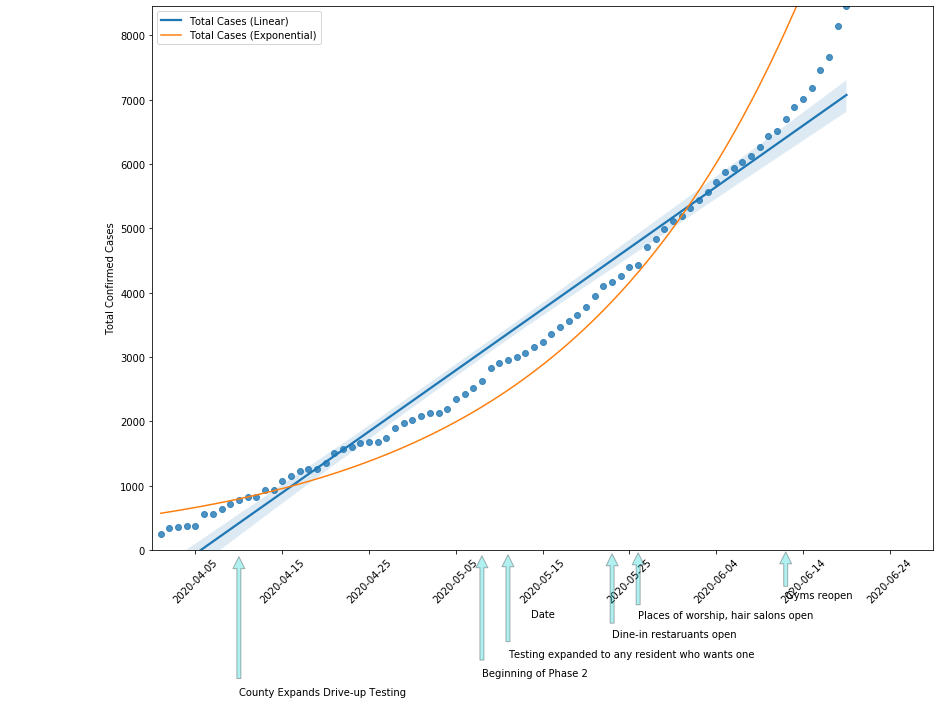

In [23]:
#Plot scatter plot for total case count
x = df_sb['date_ordinal']
y1 = df_sb['Total Count Confirmed']
y2 = df_sb['Total Count Deaths']

plt.figure(figsize=(14,10))
ax = plt.subplot(1,1,1)

# Plot scatter plot along with linear regression line
sns.regplot(x='date_ordinal', y='Total Count Confirmed', data=df_sb)

# Formatting axes
ax.set_xlim(x.min() - 1, x.max() + 10)
ax.set_ylim(0, y1.max() + 1)
ax.set_xlabel('Date')

labels = [dt.date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(labels)
plt.xticks(rotation = 45)
plt.ylabel("Total Confirmed Cases")

# Exponential Curve
from sklearn.linear_model import LinearRegression
x = np.array(df_sb['date_ordinal']).reshape(-1,1)
Y = np.array(np.log(df_sb['Total Count Confirmed'])).reshape(-1,1)

reg = LinearRegression().fit(x,Y)

slope = reg.coef_
intercept = reg.intercept_

plt.plot(x, np.exp(slope * x + intercept))

plt.legend(['Total Cases (Linear)', 'Total Cases (Exponential)'])

# Inserting Significant Date Labels
add_sig_dates(df_sb, 'Total Count Confirmed')

plt.show()

This graph seems to be relatively linear. However, note that there is a slight curve in the scatter plot. However, we don't seem to have enough of a curve to make this visible in our exponential model above, meaning it overlaps with our linear regression line.

However, it's obvious that in the past few days (as of 6/18/20), the number of confirmed cases has increased significantly. This alone should be a cause for concern.

## Time vs. Total Deaths
Now let's do a similar comparison with the death count.

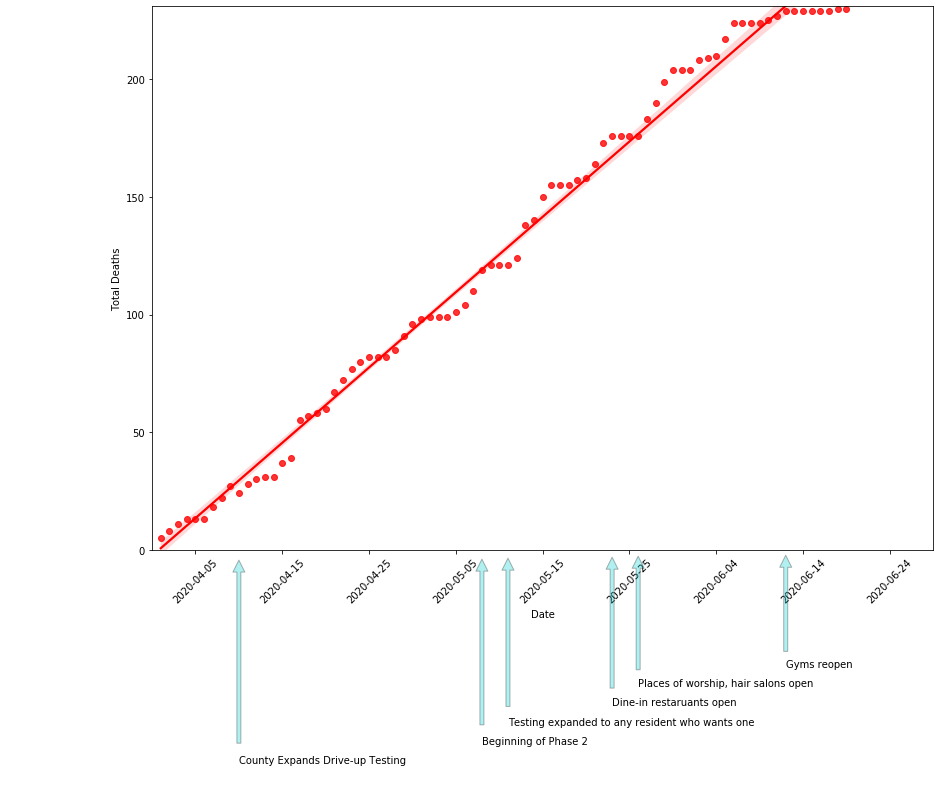

In [6]:
plt.figure(figsize=(14,10))
ax = plt.subplot(1,1,1)

sns.regplot(x='date_ordinal',y='Total Count Deaths', data=df_sb, color='red')

# Formatting axes
ax.set_xlim(x.min() - 1, x.max() + 10)
ax.set_ylim(0, y2.max() + 1)
ax.set_xlabel('Date')

labels = [dt.date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(labels)
plt.xticks(rotation = 45)
plt.ylabel("Total Deaths")

# Inserting Significant Date Labels
add_sig_dates(df_sb, 'Total Count Deaths')

plt.show()

Like our previous graph, there appears to be a mostly linear relationship between time and total deaths. While there seems to be a slight "dip" in the scatter plot, it isn't as pronounced as it is in the total cases graph.
## New cases and Deaths per Day

It may be easier to see how the outbreak in San Bernardino County is progressing through comparing new cases and new deaths per day. Essentially, if the new cases per day is increasing, the spread of the virus is accelerating and vicaversa. Note that I'm speaking in generalities and there may be other factors influencing the data.

In [7]:
# Generate column with new cases and new deaths.
lag = df_sb[['Total Count Confirmed', 'Total Count Deaths']].shift(1)
df_sb['New Confirmed Cases'] = df_sb['Total Count Confirmed'] - lag['Total Count Confirmed']
df_sb['New Deaths'] = df_sb['Total Count Deaths'] - lag['Total Count Deaths']

# Add total counts back in for first column
df_sb.loc[1,'New Confirmed Cases'] = df_sb.loc[1,'Total Count Confirmed']
df_sb.loc[1,'New Deaths'] = df_sb.loc[1,'Total Count Deaths']

df_sb.head(5)

,County Name,Most Recent Date,Total Count Confirmed,Total Count Deaths,COVID-19 Positive Patients,Suspected COVID-19 Positive Patients,ICU COVID-19 Positive Patients,ICU COVID-19 Suspected Patients,date_ordinal,New Confirmed Cases,New Deaths
1,San Bernardino,4/1/2020,245.0,5.0,95.0,196.0,39.0,52.0,737516,245.0,5.0
93,San Bernardino,4/2/2020,335.0,8.0,126.0,185.0,50.0,45.0,737517,90.0,3.0
152,San Bernardino,4/3/2020,356.0,11.0,118.0,204.0,44.0,53.0,737518,21.0,3.0
211,San Bernardino,4/4/2020,373.0,13.0,138.0,254.0,51.0,66.0,737519,17.0,2.0
270,San Bernardino,4/5/2020,375.0,13.0,146.0,240.0,59.0,54.0,737520,2.0,0.0


A quick check of the data shows our new columns are indeed the differences between each entry for confirmed cases and confirmed deaths.
## New cases per Day
Now let's plot our new cases column against time.

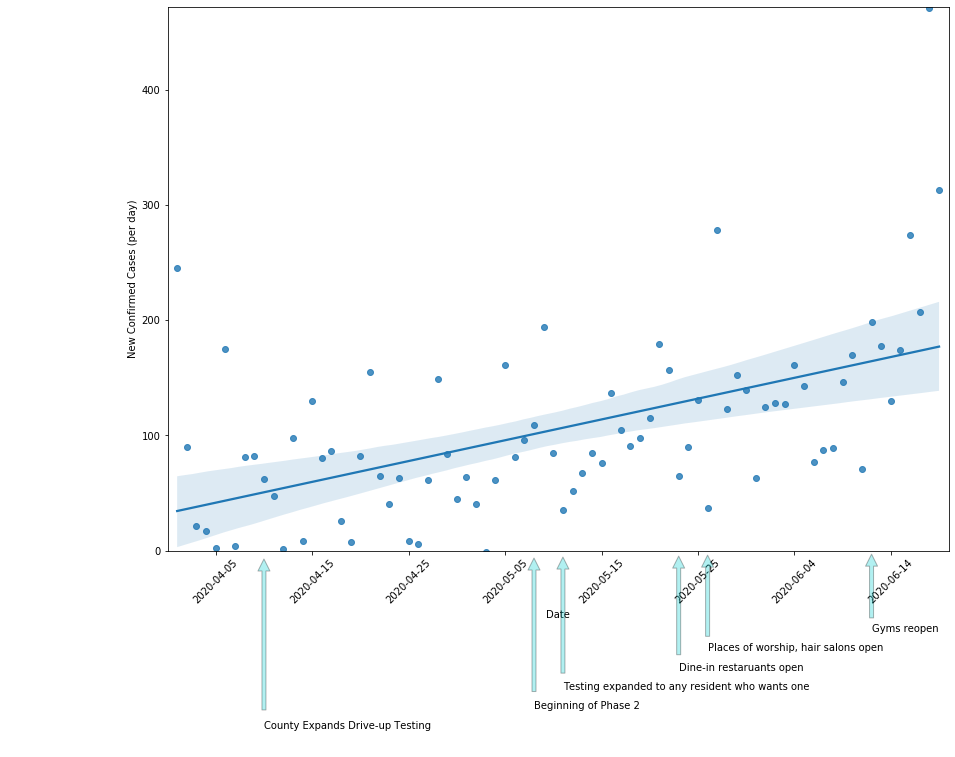

In [8]:
# Plotting new cases per day
plt.figure(figsize=(14,10))
ax = sns.regplot(data=df_sb, x='date_ordinal', y='New Confirmed Cases')

# Formatting
ax.set_xlim(df_sb['date_ordinal'].min() - 1, df_sb['date_ordinal'].max() + 1)
ax.set_ylim(0, df_sb['New Confirmed Cases'].max() + 1)

# Set axis labels
ax.set_xlabel('Date')
new_labels = [dt.date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)
plt.xticks(rotation = 45)
plt.ylabel("New Confirmed Cases (per day)")

# Inserting Significant Date Labels
add_sig_dates(df_sb, 'New Confirmed Cases')

plt.show()

The data suggests a (somewhat tenuous) upward trend in confirmed cases per day in SB county over time. Therefore, the spread of the virus seems to be accelerating by looking at this graph. However, we must not forget that earlier in the pandemic, tests were much scarcer and reserved for those who were at risk and/or likely to have contracted the disease. Therefore, some of the increase may be due to more people being tested than before. More on this later.

Also, notice that the *trend* is upward. It's actually difficult to predict the exact number of confirmed cases per day given the amount of variability in the data.
## New Deaths per Day
Now let's do the same for deaths

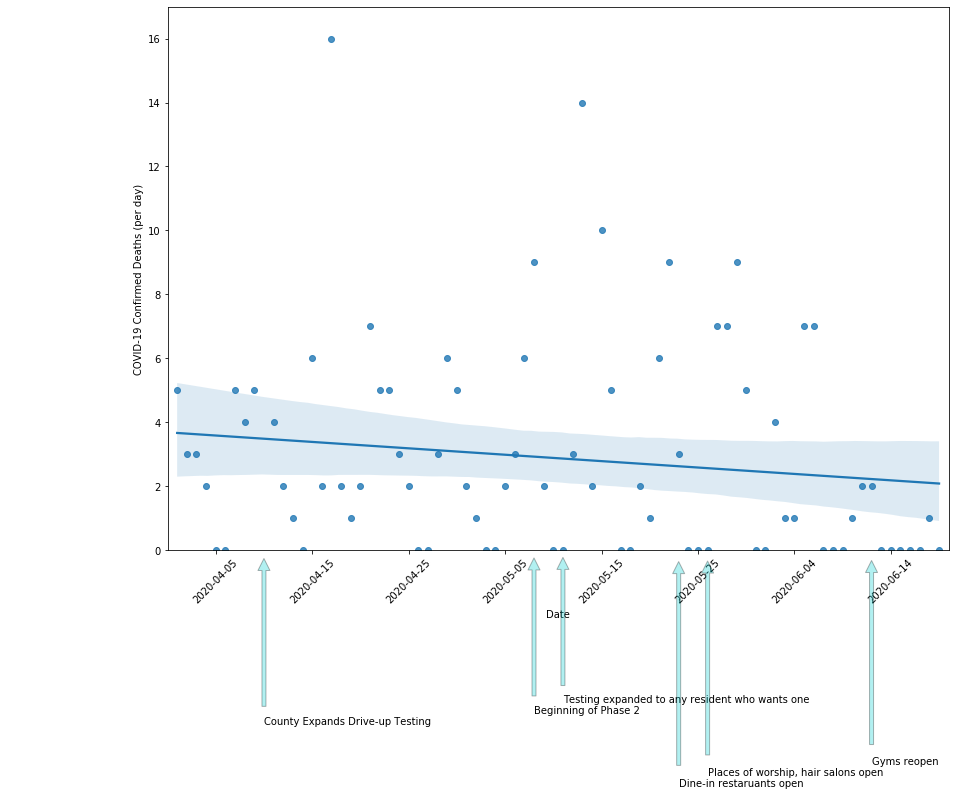

In [9]:
# Plotting new deaths per day
plt.figure(figsize=(14,10))
ax = sns.regplot(data=df_sb, x='date_ordinal', y='New Deaths')

# Formatting
ax.set_xlim(df_sb['date_ordinal'].min() - 1, df_sb['date_ordinal'].max() + 1)
ax.set_ylim(0, df_sb['New Deaths'].max() + 1)

# Set axis labels
ax.set_xlabel('Date')
new_labels = [dt.date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)
plt.xticks(rotation = 45)
plt.ylabel("COVID-19 Confirmed Deaths (per day)")

# Inserting Significant Date Labels
# Modified the earlier date insert function to accomodate the smaller values
def smaller_dates(dataframe, y_column):
    i = dataframe[y_column].max()*0.05
    for entry in sorted(sig_dates):
        plt.annotate(entry[1], xy=(entry[0], 0),
                 xytext=(entry[0], -5-i),
                 arrowprops=dict(facecolor='darkturquoise', shrink=0.05, alpha=0.3))
        if i <= 0:
            i = dataframe[y_column].max()*0.15
        else:
            i -= dataframe[y_column].max()*0.15/7

smaller_dates(df_sb, 'New Deaths')
                
plt.show()

There currently appears to be a vaguely decreasing relationship between time and new deaths per day. This is interesting since, the number of confirmed COVID-related deaths is not. This may be because increasing testing availability has allowed people with less serious cases to confirm that they have been infected with COVID while deaths are often harder (but not impossible) to miss.

In [10]:
# We will calculate pearson correlation coefficients on all columns to see if there are other relationships we'd like to investigate.
pearsoncorr = df_sb.corr(method='pearson')
pearsoncorr

,Total Count Confirmed,Total Count Deaths,COVID-19 Positive Patients,Suspected COVID-19 Positive Patients,ICU COVID-19 Positive Patients,ICU COVID-19 Suspected Patients,date_ordinal,New Confirmed Cases,New Deaths
Total Count Confirmed,1.000000,0.970674,0.658867,-0.677052,0.640365,-0.646007,0.983177,0.602119,-0.168072
Total Count Deaths,0.970674,1.000000,0.504019,-0.748237,0.491635,-0.739524,0.995009,0.502652,-0.100377
COVID-19 Positive Patients,0.658867,0.504019,1.000000,-0.353406,0.901914,-0.299124,0.568113,0.493291,-0.285237
Suspected COVID-19 Positive Patients,-0.677052,-0.748237,-0.353406,1.000000,-0.276959,0.902967,-0.749828,-0.283551,0.014657
ICU COVID-19 Positive Patients,0.640365,0.491635,0.901914,-0.276959,1.000000,-0.210734,0.542335,0.441549,-0.339732
ICU COVID-19 Suspected Patients,-0.646007,-0.739524,-0.299124,0.902967,-0.210734,1.000000,-0.737807,-0.268194,-0.024494
date_ordinal,0.983177,0.995009,0.568113,-0.749828,0.542335,-0.737807,1.000000,0.535505,-0.137614
New Confirmed Cases,0.602119,0.502652,0.493291,-0.283551,0.441549,-0.268194,0.535505,1.000000,0.021096
New Deaths,-0.168072,-0.100377,-0.285237,0.014657,-0.339732,-0.024494,-0.137614,0.021096,1.000000


Unsuprisingly, we have a strong positive relationship between the total confirmed cases and time. The same can be said for time and the death count. This makes sense since the data points from the first graph almost follow a line.

There is a moderate, positive correlation between time and new cases per day since the pearson correlation coefficient is around 0.5 for these two variables. As expected, there is almost 0 correlation between time and new deaths, meaning there's currently no relationship betwee time and number of deaths per day. Hopefully, this does not change to a positive (increasing) correlation as the pandemic continues.

## Case counts after testing expansion
As stated earlier, another thing we need to consider is if testing is part of the reason the confirmed cases are rising. After all, San Bernardino County (and the rest of the US for that matter) were short on COVID tests in the early days of the pandemic. Let's slice the data from the day testing got expanded to everyone and see if the increase in confirmed cases still exists.

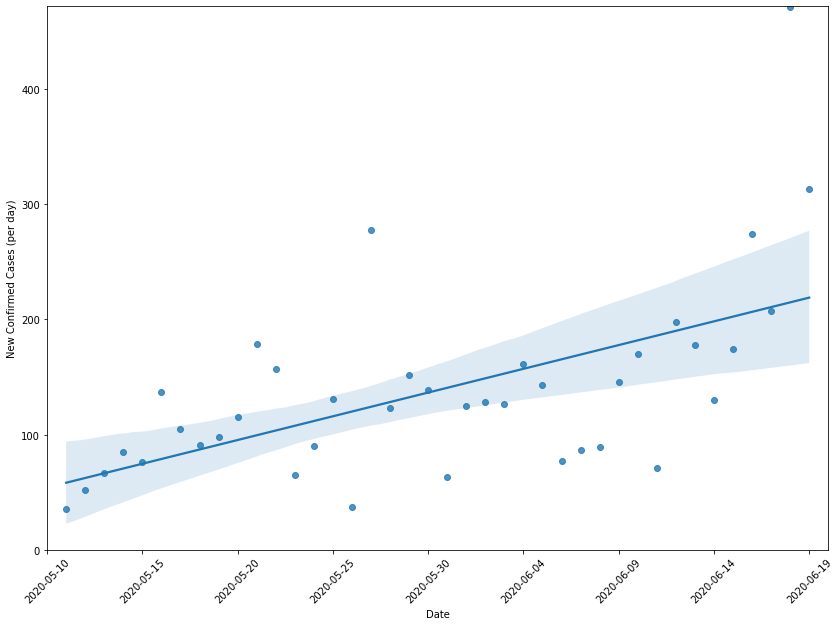

In [11]:
# Slicing our data
df_sbt = df_sb[df_sb['date_ordinal'] >= dt.date(2020, 5, 11).toordinal()]

# Plotting new cases per day
plt.figure(figsize=(14,10))
ax = sns.regplot(data=df_sbt, x='date_ordinal', y='New Confirmed Cases')

# Formatting
ax.set_xlim(df_sbt['date_ordinal'].min() - 1, df_sbt['date_ordinal'].max() + 1)
ax.set_ylim(0, df_sbt['New Confirmed Cases'].max() + 1)

# Set axis labels
ax.set_xlabel('Date')
new_labels = [dt.date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)
plt.xticks(rotation = 45)
plt.ylabel("New Confirmed Cases (per day)")

plt.show()

There appears to be a shallow but positive linear relationship between time and new cases. This shows that the confirmed cases are still increasing even after only accounting for data after testing was extended to all residents. However, the exact number of confirmed cases per day is highly variable, hence the large error shown in the regression line.

In [12]:
pearsoncorr = df_sbt.corr(method='pearson')
pearsoncorr

,Total Count Confirmed,Total Count Deaths,COVID-19 Positive Patients,Suspected COVID-19 Positive Patients,ICU COVID-19 Positive Patients,ICU COVID-19 Suspected Patients,date_ordinal,New Confirmed Cases,New Deaths
Total Count Confirmed,1.000000,0.943628,0.908056,-0.396927,0.918267,-0.087912,0.993132,0.638479,-0.379462
Total Count Deaths,0.943628,1.000000,0.755480,-0.318731,0.828382,0.024937,0.970553,0.483063,-0.308869
COVID-19 Positive Patients,0.908056,0.755480,1.000000,-0.499478,0.924802,-0.150109,0.875628,0.632778,-0.384939
Suspected COVID-19 Positive Patients,-0.396927,-0.318731,-0.499478,1.000000,-0.541689,0.528983,-0.363379,-0.187129,0.173404
ICU COVID-19 Positive Patients,0.918267,0.828382,0.924802,-0.541689,1.000000,-0.102022,0.905713,0.557013,-0.451997
ICU COVID-19 Suspected Patients,-0.087912,0.024937,-0.150109,0.528983,-0.102022,1.000000,-0.020082,-0.194280,-0.222146
date_ordinal,0.993132,0.970553,0.875628,-0.363379,0.905713,-0.020082,1.000000,0.582023,-0.386392
New Confirmed Cases,0.638479,0.483063,0.632778,-0.187129,0.557013,-0.194280,0.582023,1.000000,-0.088104
New Deaths,-0.379462,-0.308869,-0.384939,0.173404,-0.451997,-0.222146,-0.386392,-0.088104,1.000000


When we limit our data to dates after testing was expanded to all interested citizens, the positive (increasing) relationship between time and new confirmed cases is lower (with the pearson correlation coeffiecent at about 0.41). However, part of the reason this correlation is so low is because we just shrunk our data set by about half the size it was before (as of June 8th). It will be interesting to see if this correlation changes overtime.

As we saw in the earlier pearson table, there does seem to be a strong-to-medium negative relationship between suspected COVID-19 hospital patients (both ICU and in general) and time. Let's investigate that.

## Suspected Cases per Day

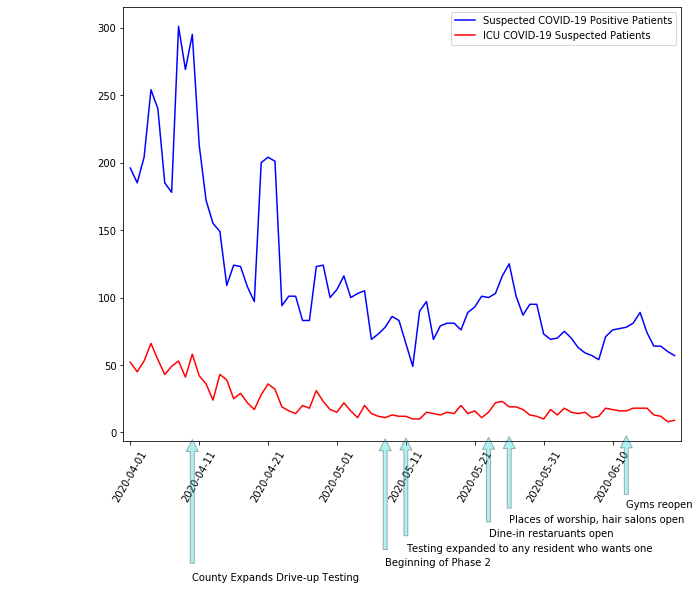

In [13]:
# Initialize plot
plt.figure(figsize=(10,8))
ax = plt.subplot()

# Plot suspected COVID cases
plt.plot(df_sb['date_ordinal'], df_sb['Suspected COVID-19 Positive Patients'], color='blue')
plt.plot(df_sb['date_ordinal'], df_sb['ICU COVID-19 Suspected Patients'], color='red')

# Formatting
ax.set_xlim(df_sb['date_ordinal'].min() - 1, df_sb['date_ordinal'].max() + 1)

# Make x-tick labels
x_ticks = []
i = 0
for item in df_sb['date_ordinal']:
    if i % 10 == 0:
        x_ticks.append(item)
    i += 1

ax.set_xticks(x_ticks)
new_labels = [dt.date.fromordinal(int(item)) for item in ax.get_xticks()]

ax.set_xticklabels(new_labels, rotation=60)

# Inserting Significant Date Labels
add_sig_dates(df_sb, 'Suspected COVID-19 Positive Patients')

plt.legend(['Suspected COVID-19 Positive Patients', 'ICU COVID-19 Suspected Patients'])
plt.show()

It appears this decrease may be due to the increase in test availability overtime, especially since we know tests were in short supply during the earlier days of the pandemic. Indeed, the correlation disappears if we limit the data set to after tests became more widely available.